# Solving the 1D Diffusion Equation with a Neural Network

In [24]:
import torch
from torch import nn
from scipy.stats.qmc import LatinHypercube
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.qmc import LatinHypercube
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import os

In [8]:
# Own implementations
%load_ext autoreload
%autoreload 2
from pinn2 import *

In [9]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

In [10]:
plt.style.use('../misc/report.mplstyle')

# Toggle to save plots as pdf
save=False
save_dir = "../../../tex/02_neural_nets_on_pdes/img/"

# Some shorthands for figure labels/legends
MSE = r"$\mathrm{MSE}_\mathcal{V}$"

In [11]:
torch.set_default_dtype(torch.float32)

### 1D Diffusion Equation

In [77]:
# Functions below specify the initial boundary value problem (in terms of its residuals/deviations) alongside its analytic solution
def u0(u, x, t):
    return u - torch.sin(torch.pi * x), torch.zeros_like(u)

def dirichlet_bc(u, x, t):
    return u, torch.zeros_like(u)

def diffusion_equation(u, x, t):
    u_t = derivative(u, t)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    
    return u_xx - u_t, torch.zeros_like(u)
diffusion_equation.domain_dim=2
diffusion_equation.target_dim=1

def u_analytical(x, t):
    return np.sin(np.pi * x) *np.exp(-(torch.pi)**2 * t)

def spatio_temportal_sample_latin_hypercube(T, N_st, N_s, N_t):
    sampler1d = lambda N: torch.from_numpy(LatinHypercube(1).random(n = N)).float()
    # Excludes boundaries naturally
    sampler2d = lambda N: torch.from_numpy(LatinHypercube(2).random(n = N)).float()
    
    #Interior points
    samples_xt = sampler2d(N_st)
    samples_xt[:,1] *= T
    
    # Spatial points at t=0 (initial conditions)
    samples_x_ic = sampler1d(N_t)
    samples_t_ic = torch.zeros((N_t,1))
    
    # Temporal points at x=0,1 (boundary conditions)
    samples_t_bc = torch.repeat_interleave(T * sampler1d(N_s), 2, dim=0)
    samples_x_bc = torch.empty((2 * N_s,1))
    samples_x_bc[0::2,0] = 0.
    samples_x_bc[1::2,0] = 1.
    
    return samples_xt, \
           torch.cat((samples_x_ic, samples_t_ic),1), \
           torch.cat((samples_x_bc, samples_t_bc), 1)
    
def spatio_temportal_sample_cfl(T, N_s, cfl=lambda dx: 0.5 * dx**2):
    dx = 1.0/(N_s - 1)
    dt = cfl(dx)
    
    N_t = int(2/dx**2 + 1)
    x = torch.from_numpy(dx * np.arange(N_s)).reshape(-1,1).float()
    t = torch.from_numpy(dt * np.arange(N_t)).reshape(-1,1).float()
    
    # Spatial points at t=0 (initial conditions)
    samples_x_ic = x
    samples_t_ic = torch.zeros_like(samples_x_ic)
    
    # Interior points
    samples_xt = torch.from_numpy(np.dstack(np.meshgrid(x[1:-1], t[1:])).reshape(-1, 2)).float()
    
    # Temporal points at x=0,1 (boundary conditions)
    samples_x_bc = torch.empty((2 * N_t,1))
    samples_x_bc[0::2,0] = 0.
    samples_x_bc[1::2,0] = 1.
    samples_t_bc = torch.repeat_interleave(t, 2, dim=0)
    
    return samples_xt, \
           torch.cat((samples_x_ic, samples_t_ic),1), \
           torch.cat((samples_x_bc, samples_t_bc), 1)

### Generate Test/Train Split

In [82]:
def unpack_sample(xt):
    return xt[:,0].reshape(-1,1), xt[:,-1].reshape(-1,1)

#IBVP parameters
T = 1
N_interior =  2**10
N_bc = 2**9
N_ic = 2**7
X_train = spatio_temportal_sample_latin_hypercube(T, N_interior, N_bc, N_ic)

N_ic_test = 11 
X_test = spatio_temportal_sample_cfl(T, N_ic_test)

torch.Size([1791, 2]) torch.Size([11, 2]) torch.Size([400, 2])


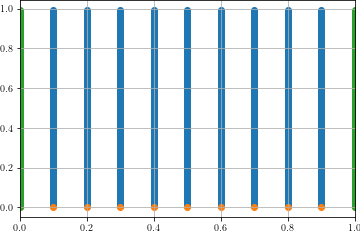

In [84]:
xt_int, xt_ic, xt_bc = X_test
print(xt_int.shape, xt_ic.shape, xt_bc.shape)
plt.scatter(*unpack_sample(xt_int))
plt.scatter(*unpack_sample(xt_ic))
plt.scatter(*unpack_sample(xt_bc))
plt.show()

### Training of the Network

In [93]:
def early_convergence(loss):
    if np.abs(1.0 - loss / early_convergence.last_loss) < 1e-10:
        return True
    else:
        early_convergence.last_loss = loss
        return False
early_convergence.last_loss = np.inf
early_convergence.terminate = True

diffusion_nn = PiNN(diffusion_equation, u0, dirichlet_bc, events_for_loss=[early_convergence], verbose=True)
#print(diffusion_nn)
diffusion_nn.fit(X_train)

-----------------------------Training Log-----------------------------
# of collocation points:                                          1024
# of boundary points:                                             1024
# of initial condition:                                            128
Points per Iteration:                                           2176.0
----------------------------------------------------------------------
  Epoch   |  Total Loss   |  Loss (PDE)   |   Loss (BC)   |   Loss (IC)   
    0     |  1.35803e-01  |  3.33626e-03  |  5.10659e-02  |  8.14008e-02  
    20    |  1.42440e-04  |  1.26215e-04  |  1.38083e-05  |  2.41703e-06  
    40    |  2.97854e-05  |  2.60273e-05  |  3.06890e-06  |  6.89145e-07  
    60    |  1.44803e-05  |  1.14094e-05  |  2.83535e-06  |  2.35469e-07  
    80    |  1.01809e-05  |  9.32549e-06  |  6.51891e-07  |  2.03475e-07  
early_convergence fired terminal event after 81 epochs


## Hyperparameter Tuning

### Randomized Parameter Sweep

In [85]:
from ray.tune.schedulers import ASHAScheduler

def no_increasing_loss(trial_id, result):
    if result["training_iteration"] == 1:
        no_increasing_loss.max_loss = result["validation_loss"]
        return False
    return result["validation_loss"] > no_increasing_loss.max_loss

parameter_space = {
    "layers": tune.randint(1, 4),
    "nodes": tune.randint(5,40),
    "lr": tune.loguniform(1e-4, 1e-1),
    "optimizer_name": tune.choice(["lbfgs","adam"]),
    "number_of_minibatches": 1
    "activation_function": nn.Tanh()
}
reasonable_start = [
    {
        "layers": 3,
        "nodes": 20,
        "lr": 1e-3,
        "optimizer_name": "lbfgs"
    }
]

fixed_parameters = {
    "epochs": 1000
}


diffusion_nn = PiNN(diffusion_equation, u0, dirichlet_bc, hyperparameters=fixed_parameters, verbose=False)
scheduler=ASHAScheduler(max_t=fixed_parameters["epochs"], grace_period=5, brackets=3)

analysis = tune.run(tune.with_parameters(diffusion_nn.train, X_train=X_train, X_test=X_test),
                    config=parameter_space,
                    num_samples=200,
                    max_failures=2,
                    metric="validation_loss",
                    mode="min",
                    scheduler=scheduler,
                    stop=no_increasing_loss,
                    local_dir="../data/ray",
                    name="diffusion_pinn",
                    resume="AUTO",
                    verbose=1)

2022-04-24 19:28:14,564	INFO tune.py:701 -- Total run time: 110.71 seconds (110.55 seconds for the tuning loop).


{'layers': 3, 'nodes': 36, 'lr': 0.0936173129464164, 'optimizer_name': 'lbfgs', 'number_of_minibatches': 1}


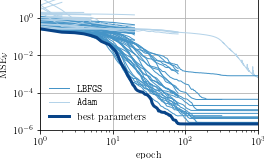

In [88]:
save=True
size = (3.9, 0.618 * 3.9) if save else (10,6)

fig, ax = plt.subplots(figsize=size)
ax.set_xscale("log")
ax.set_yscale("log")

dfs = analysis.trial_dataframes
best_df = analysis.best_dataframe
best_cfg = analysis.best_config
print(best_cfg)

blues = sns.color_palette("Blues",12)

for k,d in dfs.items():
    if "adam" in k:
        line_adam, = ax.plot(d.training_iteration, d.validation_loss, color=blues[3], lw=1)
    else:
        line_lbfgs, = ax.plot(d.training_iteration, d.validation_loss, color=blues[7], lw=1)
        
ax.plot(best_df.training_iteration, best_df.validation_loss, color=blues[11], lw=3, label=r"best parameters")
line_adam.set_label(rf"\texttt{{Adam}}")
line_lbfgs.set_label(rf"\texttt{{LBFGS}}")
ax.set_ylim([1e-6,1e1])
ax.set_xlabel(r"epoch")
ax.set_ylabel(MSE)
handles, labels = ax.get_legend_handles_labels()
#handles[0], handles[1] = handles[1], handles[0]
#labels[0], labels[1] = labels[1], labels[0]
ax.legend(handles, labels)

if save:
    fig.savefig(save_dir + "hyperopt_diffusion.pdf",bbox_inches="tight",pad_inches = 0.02)
else:
    plt.show()

In [89]:
logdir = analysis.best_logdir
best_cfg["hidden_layers"] = best_cfg["layers"] * [best_cfg["nodes"]]
best_cfg["optimizer_params"] = {"lr":best_cfg["lr"]}
best_cfg = best_cfg | fixed_parameters
state_dict = torch.load(os.path.join(logdir, "model.pth"))
print(best_cfg)

{'layers': 3, 'nodes': 36, 'lr': 0.0936173129464164, 'optimizer_name': 'lbfgs', 'number_of_minibatches': 1, 'hidden_layers': [36, 36, 36], 'optimizer_params': {'lr': 0.0936173129464164}, 'epochs': 1000}


### Comparison between PiNN and Analytical Solution

In [90]:
best_diffusion_nn = PiNN(diffusion_equation, u0, dirichlet_bc, hyperparameters=best_cfg, verbose=False)
best_diffusion_nn.net.load_state_dict(state_dict)

<All keys matched successfully>

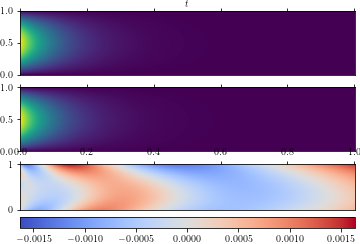

In [91]:
def dstack_product(x, y):
     return np.dstack(np.meshgrid(x, y)).reshape(-1, 2)
    
N_t = 1000
N_x = 900
t = np.linspace(0, T, N_t)
x = np.linspace(0, 1, N_x)
xx, tt = np.meshgrid(x,t)
u_ana = u_analytical(xx,tt)
xt = dstack_product(x,t)

X_test = torch.from_numpy(xt).float()
u_net = best_diffusion_nn.predict(X_test).reshape(N_t, N_x)

fig, ax = plt.subplots(nrows=3, sharex=True)

for a in ax:
    a.grid(False)
    a.xaxis.tick_top()
    a.xaxis.set_label_position('top') 
for tk in ax[0].get_xticklabels():
    tk.set_visible(True)
for tk in ax[-1].get_xticklabels():
    tk.set_visible(True)
    
divider = make_axes_locatable(ax[2])
cax = divider.new_vertical(size="25%", pad=0.1, pack_start=True)
cax.grid(False)
fig.add_axes(cax)
    
ax[0].pcolormesh(tt,xx,u_ana)
ax[1].pcolormesh(tt,xx,u_net)
im = ax[2].pcolormesh(tt, xx, u_net-u_ana,
                      cmap="coolwarm",
                      norm=colors.CenteredNorm())

cax.set_xlabel(r"$u_\text{analytical} - u_{net}$")
fig.colorbar(im, cax=cax, orientation="horizontal")

ax[0].set_xlabel(r"$t$")
plt.show()

In [52]:
N_s = 10
cfl=lambda dx: 1.0/2 * dx**2
dx = 1.0/(N_s - 1)
dt = cfl(dx)
    
x = dx * np.arange(N_s)
t = dt * np.arange(2/dx**2 + 1)
print(x)
print(t)
print(1.0/cfl(x[-1]) * N_s)

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
[0.         0.00617284 0.01234568 0.01851852 0.02469136 0.0308642
 0.03703704 0.04320988 0.04938272 0.05555556 0.0617284  0.06790123
 0.07407407 0.08024691 0.08641975 0.09259259 0.09876543 0.10493827
 0.11111111 0.11728395 0.12345679 0.12962963 0.13580247 0.14197531
 0.14814815 0.15432099 0.16049383 0.16666667 0.17283951 0.17901235
 0.18518519 0.19135802 0.19753086 0.2037037  0.20987654 0.21604938
 0.22222222 0.22839506 0.2345679  0.24074074 0.24691358 0.25308642
 0.25925926 0.2654321  0.27160494 0.27777778 0.28395062 0.29012346
 0.2962963  0.30246914 0.30864198 0.31481481 0.32098765 0.32716049
 0.33333333 0.33950617 0.34567901 0.35185185 0.35802469 0.36419753
 0.37037037 0.37654321 0.38271605 0.38888889 0.39506173 0.40123457
 0.40740741 0.41358025 0.41975309 0.42592593 0.43209877 0.4382716
 0.44444444 0.45061728 0.45679012 0.46296296 0.4691358  0.47530864
 0.48148148 0.4876